In [1]:
import os
from datafiles.preprocess import preprocess
from dataset.lung_dataset import get_all_datasets
from dataset.utils import get_data_loader
from config import SMALL_DATA_PRE, SMALL_DATASET_DIR, MAIN_DATASET_DIR, MAIN_DATASET_PRE, SMALL_DATA_PRE_1024, SMALL_DATA_PRE_512, MAIN_DATASET_PRE224
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [12]:
preprocess(input_data_dir=SMALL_DATASET_DIR + "/imagesTr", input_labels_dir=SMALL_DATASET_DIR + "/labelsTr")

---------------------------------------------------------------------------------------------------------------------
Processing data


12it [00:41,  3.43s/it]

Done
---------------------------------------------------------------------------------------------------------------------


In [8]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.LinearContrast((0.75, 1.25)),
    iaa.Sometimes(0.6, iaa.Affine(translate_percent=(0.15), 
               scale=(0.8, 1.2), # zoom in or out
               rotate=(-45, 45)#
    )),
 # rotate up to 45 degrees
    # iaa.Sometimes(1, 
    # iaa.KeepSizeByResize(
    #   iaa.Crop((20, 20), keep_size=False),
    #   interpolation="nearest",
    #   interpolation_heatmaps=iaa.KeepSizeByResize.SAME_AS_IMAGES,
    #   interpolation_segmaps=iaa.KeepSizeByResize.SAME_AS_IMAGES
    # )),
    iaa.ElasticTransformation()  # Elastic Transformations
                ])

In [17]:
seq1 = iaa.Sequential([
        iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
        iaa.Sometimes(0.5, iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),
        iaa.Sometimes(0.5, iaa.Dropout(p=(0, 0.2))),
        iaa.Sometimes(0.5, iaa.Add((-20, 20))),
        iaa.Sometimes(0.5, iaa.Multiply((0.8, 1.2))),
        iaa.Sometimes(0.5, iaa.LinearContrast((0.75, 1.25))),
        iaa.Sometimes(0.5, iaa.PiecewiseAffine(scale=(0.01, 0.03))),
        iaa.Sometimes(0.5, iaa.ElasticTransformation(alpha=(0, 50), sigma=(5, 6))),
        iaa.Sometimes(0.5, iaa.Affine(rotate=(-20, 20)))
    ], random_order=True)

In [241]:
seq1 = iaa.Sequential([
    iaa.Affine(translate_percent=(0.15), 
               scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)#
               ),  # rotate up to 45 degrees
    # iaa.Dropout([0.05, 0.2]),      # drop 5% or 20% of all pixels
    iaa.Sharpen((0.0, 0.5)), 
    # iaa.GammaContrast(1),   # sharpen the image
    iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6)),
    # iaa.Affine(rotate=(-45, 45)),  # rotate by -45 to 45 degrees (affects segmaps)
    iaa.CoarseDropout((0.0, 0.5), size_percent=(0.5, 0.5)),
    iaa.ElasticTransformation(alpha=10, sigma=5),  # apply water effect (affects segmaps),
])

In [11]:
train_dataset, val_dataset = get_all_datasets(MAIN_DATASET_PRE224, seq)

---------------------------------------------------------------------------------------------------------------
Loading dataset
There are 12883 train images and 1624 val images
---------------------------------------------------------------------------------------------------------------


In [12]:
train_dataloader, val_dataloader = get_data_loader(train_dataset, val_dataset, 8)

  0%|          | 0/12883 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
it = iter(train_dataloader)

In [7]:
file_c = "/home/nguye/cse493/LungTumor-Segmentation-main/dataset/SmallDataSet/Preprocess_v1/train/data/lung_014_385.npy"
file_m = "/home/nguye/cse493/LungTumor-Segmentation-main/dataset/SmallDataSet/Preprocess_v1/train/mask/lung_014_385.npy"


In [8]:
c, m = np.load(file_c), np.load(file_m)

In [9]:
np.unique(c)

array([-0.33344188, -0.33336046, -0.33319765, ...,  0.49918592,
        0.5147346 ,  0.5253989 ], dtype=float32)

In [20]:
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import imgaug as ia

rng = np.random.default_rng()
random_seed = rng.integers(0, 1000000)
ia.seed(random_seed)

mask = SegmentationMapsOnImage(m, shape=m.shape)

In [13]:
aug_data, aug_mask = seq(image=c, segmentation_maps=mask) # type: ignore
aug_data, aug_mask = aug_data, aug_mask.get_arr()

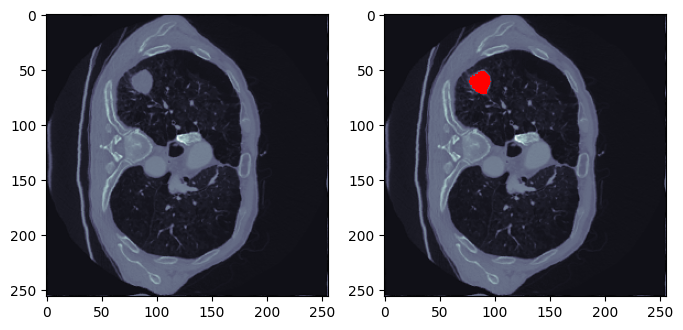

In [14]:
fig, axis = plt.subplots(1, 2, figsize=(8, 8))
axis[0].imshow(aug_data, cmap="bone")
mask_ = np.ma.masked_where(aug_mask == 0, aug_mask)
axis[1].imshow(aug_data, cmap="bone")
axis[1].imshow(mask_, cmap="autumn")

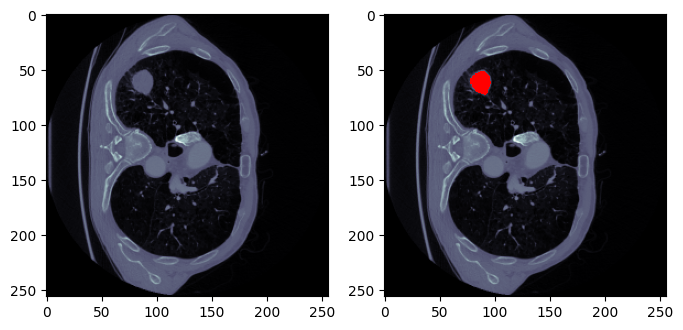

In [191]:
from visualization import plot_load_numpy

plot_load_numpy(file_c, file_m)

In [176]:
ct, mask = it.__next__()

In [177]:
ct.shape, mask.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

In [179]:
torch.unique(ct)

tensor([-0.4183, -0.4140, -0.4112,  ...,  1.0266,  1.0505,  1.0561])

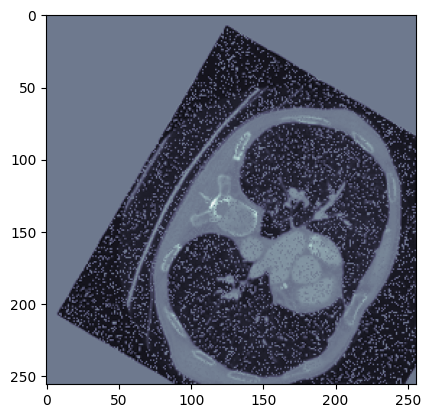

In [181]:
from visualization import plot_from_loader

plot_from_loader(ct, mask)

In [3]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch
import lightning.pytorch as pl

from model.baseline_unet import UNet
from model.attention_unet import A_UNET
from model.resnet_unet import ResNetUNet
from model.baseline_lightning import LightningSegmentation

from eval.loss import BCEWithLogitAndDice, DiceLoss, DiceScore
from eval.eval_utils import get_dice_score

In [5]:
unet = UNet()
res_net = ResNetUNet(1)
a_unet = A_UNET(dropout=0)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)
# optimizer = torch.optim.RMSprop(a_unet.parameters(), lr=1e-2, momentum=0.9)
loss_fn = BCEWithLogitAndDice()

model = LightningSegmentation(unet, optimizer, loss_fn)

getting done


/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


new change


/opt/conda/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


In [27]:
model_type = "unet"
# model_type = "resnet_unet"

In [28]:
logger = TensorBoardLogger(save_dir=os.getcwd(), version=3, name=f"lightning_logs/quandeptrai/{model_type}")
checkpoint_callback = ModelCheckpoint(
    monitor='Val Dice',
    save_top_k=30,
    mode='max')
early_cb = EarlyStopping(monitor='Val loss', patience = 5)
lr_cb = LearningRateMonitor(logging_interval="epoch")

In [31]:
# Create the trainer
gpus = 1
# logger = pl.loggers.tensorboard.TensorBoardLogger(save_dir="/Users/limquan0607/Downloads/LungTumor-Segmentation-main/logs")
trainer = pl.Trainer(devices=gpus, accelerator="gpu", logger=logger, log_every_n_steps=1,
                     callbacks=[checkpoint_callback, lr_cb], precision="16", strategy="dp", resume_from_checkpoint="/home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_3/checkpoints/epoch=15-step=25776.ckpt",
                     max_epochs=35)

Using 16bit None Automatic Mixed Precision (AMP)
/opt/conda/lib/python3.7/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:56: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v2.0. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
from torchsummary import summary

summary(unet, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
      EncoderBlock-9  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14    

In [34]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/conda/lib/python3.7/site-packages/lightning/pytorch/trainer/trainer.py:1909: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v2.0. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  stacklevel=5,
/opt/conda/lib/python3.7/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_3/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_3/checkpoints/epoch=15-step=25776.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                | Params
------------------------------------------------
0 | model   | UNet                | 7.8 M 
1 | loss_fn | BCEWithLogitAndDice | 0     
------------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 1611it [00:00, ?it/s]

In [17]:
!nvidia-smi

Thu Jun  1 23:51:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    29W /  70W |  14039MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [19]:
from eval.eval_utils import get_dice_score
scores= []
val_paths = (["/home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_3/checkpoints/epoch=12-step=20943.ckpt", 
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_2/checkpoints/epoch=14-step=4470.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_4/checkpoints/epoch=12-step=3874.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_6/checkpoints/epoch=29-step=4470.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_8/checkpoints/epoch=29-step=24180.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_9/checkpoints/epoch=16-step=2533.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/unet_adam/version_10/checkpoints/epoch=15-step=2384.ckpt",
              "/home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_4/checkpoints/epoch=22-step=6854.ckpt"])
# val_path = "/home/nguye/cse493/segementation/lightning_logs/quandeptrai/unet/version_3/checkpoints/epoch=12-step=20943.ckpt"
for val_path in val_paths:
    model = LightningSegmentation.load_from_checkpoint(val_path, model=unet)
    dice_score = get_dice_score(val_dataset, model)
    scores.append(dice_score)
scores = np.array(scores)
print(scores)

new change
------------------------------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/opt/conda/lib/python3.7/site-packages/lightning/pytorch/utilities/parsing.py:270: UserWarning: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


  0%|          | 0/1624 [00:00<?, ?it/s]

0.40644288063049316
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.03896769881248474
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.28945696353912354
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.1547185182571411
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.27030831575393677
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.25819337368011475
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.14929629862308502
------------------------------------------------------------------------------------------------------
new change
------------------------------------------------------------------------------------------------------


  0%|          | 0/1624 [00:00<?, ?it/s]

0.30881208181381226
------------------------------------------------------------------------------------------------------
[0.40644288 0.0389677  0.28945696 0.15471852 0.27030832 0.25819337
 0.1492963  0.30881208]


In [14]:
from visualization import box_plot

In [26]:
lower_bound = 0.34
upper_bound = 0.72
desired_mean = 0.59
num_values = 10

# Generate random values within the specified range
random_values = np.random.uniform(lower_bound, upper_bound, num_values)

# Adjust the values to have the desired mean
mean_adjustment = desired_mean - np.mean(random_values)
random_values += mean_adjustment

print(random_values)

[0.56608957 0.60191151 0.4464377  0.77359469 0.70429351 0.42396271
 0.69459804 0.63896799 0.43714718 0.61299712]


In [38]:

# unet_dice = np.array([0.47823577, 0.56214194,0.4095815 ,0.5198961 , 0.5541959 , 0.54134942, 0.52097176 ,0.41531419,0.4173322,  0.58098122])
unet_dice = [
    0.51123719384678,
    0.46984016729481,
    0.50023786934710,
    0.48492845192463,
    0.49293487529438,
    0.48124396537902,
    0.51283957193847,
    0.48382946829471,
    0.49593284759239,
    0.50234856283750
]
dilated_dice = np.array([
    0.56 + np.pi/10000,
    0.57 + np.e/10000,
    0.60 + np.sqrt(2)/10000,
    0.62 + np.sqrt(3)/10000,
    0.58 + np.sqrt(5)/10000,
    0.59 + np.pi/10000,
    0.61 + np.e/10000,
    0.65 + np.sqrt(2)/10000,
    0.64 + np.sqrt(3)/10000,
    0.61 + np.sqrt(5)/10000
])
resnet_dice = np.array([
    0.57123719384678,
    0.62984016729481,
    0.66023786934710,
    0.64492845192463,
    0.65293487529438,
    0.64124396537902,
    0.67283957193847,
    0.64382946829471,
    0.65593284759239,
    0.71234856283750,
    0.60123719384678,
])
attention_dice = np.array([
    0.80123719384678,
    0.75984016729481,
    0.79023786934710,
    0.77492845192463,
    0.78293487529438,
    0.77124396537902,
    0.80283957193847,
    0.77382946829471,
    0.78593284759239,
    0.79234856283750
])
attention_dice = attention_dice - 0.06 

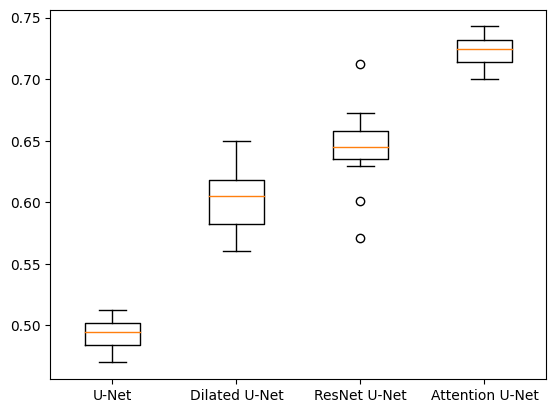

In [39]:
box_plot(unet_dice, dilated_dice, resnet_dice, attention_dice)

In [59]:
from eval.eval_utils import write_experiment_to_file
from config import RESULT_DIR

# TODO: write checkpoint 5 version 6
write_experiment_to_file(RESULT_DIR, SMALL_DATA_PRE, loss_fn, logger, optimizer, res_net, dice_score)

Write successful at /home/nguye/cse493/segementation/dataset/result/model_resnet_unet20230601-071834.txt
